In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/dynamic_rcnn/dynamic_rcnn_r50_fpn_1x.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'lotte_data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/JPEGImages'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'lotte_data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/JPEGImages'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'lotte_data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/JPEGImages'

# num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 22
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(typ

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-28 12:31:30,556 - mmdet - INFO - load model from: torchvision://resnet50
2020-09-28 12:31:30,669 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-09-28 12:31:37,653 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-09-28 12:31:37,653 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2020-09-28 12:31:44,325 - mmdet - INFO - Epoch [1][10/587]	lr: 4.746e-05, eta: 1:17:02, time: 0.657, data_time: 0.212, memory: 3790, loss_rpn_cls: 0.6938, loss_rpn_bbox: 0.0767, loss_cls: 2.8282, acc: 30.5371, loss_bbox: 0.0017, loss: 3.6003
2020-09-28 12:31:48,267 - mmdet - INFO - Epoch [1][20/587]	lr: 9.741e-05, eta: 1:01:32, time: 0.394, data_time: 0.013, memory: 3790, loss_rpn_cls: 0.6881, loss_rpn_bbox: 0.0759, loss_cls: 0.9522, acc: 97.8320, loss_bbox: 0.0016, loss: 1.7178
2020-09-28 12:31:52,331 - mmdet - 

2020-09-28 12:34:00,342 - mmdet - INFO - Epoch [1][330/587]	lr: 1.646e-03, eta: 0:48:20, time: 0.430, data_time: 0.013, memory: 3790, loss_rpn_cls: 0.0288, loss_rpn_bbox: 0.0700, loss_cls: 0.2973, acc: 89.9805, loss_bbox: 0.2693, loss: 0.6654
2020-09-28 12:34:04,364 - mmdet - INFO - Epoch [1][340/587]	lr: 1.696e-03, eta: 0:48:10, time: 0.402, data_time: 0.013, memory: 3790, loss_rpn_cls: 0.0231, loss_rpn_bbox: 0.0528, loss_cls: 0.3292, acc: 89.0723, loss_bbox: 0.3217, loss: 0.7268
2020-09-28 12:34:08,578 - mmdet - INFO - Epoch [1][350/587]	lr: 1.746e-03, eta: 0:48:04, time: 0.419, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0204, loss_rpn_bbox: 0.0521, loss_cls: 0.3055, acc: 89.7559, loss_bbox: 0.3276, loss: 0.7057
2020-09-28 12:34:12,901 - mmdet - INFO - Epoch [1][360/587]	lr: 1.796e-03, eta: 0:48:00, time: 0.434, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0203, loss_rpn_bbox: 0.0554, loss_cls: 0.2999, acc: 89.9219, loss_bbox: 0.3031, loss: 0.6788
2020-09-28 12:34:17,329 - mm

2020-09-28 12:36:32,814 - mmdet - INFO - Epoch [2][90/587]	lr: 2.500e-03, eta: 0:45:46, time: 0.433, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0075, loss_rpn_bbox: 0.0394, loss_cls: 0.1855, acc: 93.6523, loss_bbox: 0.1644, loss: 0.3968
2020-09-28 12:36:37,243 - mmdet - INFO - Epoch [2][100/587]	lr: 2.500e-03, eta: 0:45:43, time: 0.444, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0111, loss_rpn_bbox: 0.0442, loss_cls: 0.2028, acc: 94.4434, loss_bbox: 0.1594, loss: 0.4174
2020-09-28 12:36:41,480 - mmdet - INFO - Epoch [2][110/587]	lr: 2.500e-03, eta: 0:45:38, time: 0.424, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0112, loss_rpn_bbox: 0.0432, loss_cls: 0.1572, acc: 93.7695, loss_bbox: 0.1492, loss: 0.3608
2020-09-28 12:36:45,747 - mmdet - INFO - Epoch [2][120/587]	lr: 2.500e-03, eta: 0:45:33, time: 0.427, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0100, loss_rpn_bbox: 0.0508, loss_cls: 0.1910, acc: 93.0176, loss_bbox: 0.1663, loss: 0.4181
2020-09-28 12:36:49,957 - mmd

2020-09-28 12:39:00,172 - mmdet - INFO - Epoch [2][430/587]	lr: 2.500e-03, eta: 0:43:24, time: 0.443, data_time: 0.017, memory: 3790, loss_rpn_cls: 0.0087, loss_rpn_bbox: 0.0383, loss_cls: 0.1394, acc: 95.0781, loss_bbox: 0.1216, loss: 0.3080
2020-09-28 12:39:04,281 - mmdet - INFO - Epoch [2][440/587]	lr: 2.500e-03, eta: 0:43:18, time: 0.414, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0397, loss_cls: 0.1505, acc: 94.6973, loss_bbox: 0.1453, loss: 0.3417
2020-09-28 12:39:08,652 - mmdet - INFO - Epoch [2][450/587]	lr: 2.500e-03, eta: 0:43:14, time: 0.436, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0081, loss_rpn_bbox: 0.0379, loss_cls: 0.1491, acc: 94.0430, loss_bbox: 0.1381, loss: 0.3333
2020-09-28 12:39:13,002 - mmdet - INFO - Epoch [2][460/587]	lr: 2.500e-03, eta: 0:43:10, time: 0.434, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0072, loss_rpn_bbox: 0.0453, loss_cls: 0.1418, acc: 94.5703, loss_bbox: 0.1473, loss: 0.3416
2020-09-28 12:39:17,384 - mm

2020-09-28 12:41:31,406 - mmdet - INFO - Epoch [3][190/587]	lr: 2.500e-03, eta: 0:40:47, time: 0.412, data_time: 0.017, memory: 3790, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0301, loss_cls: 0.1289, acc: 95.0586, loss_bbox: 0.1347, loss: 0.2981
2020-09-28 12:41:35,854 - mmdet - INFO - Epoch [3][200/587]	lr: 2.500e-03, eta: 0:40:43, time: 0.443, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0070, loss_rpn_bbox: 0.0415, loss_cls: 0.1412, acc: 94.9121, loss_bbox: 0.1218, loss: 0.3115
2020-09-28 12:41:40,113 - mmdet - INFO - Epoch [3][210/587]	lr: 2.500e-03, eta: 0:40:39, time: 0.428, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0050, loss_rpn_bbox: 0.0336, loss_cls: 0.1281, acc: 95.0684, loss_bbox: 0.1236, loss: 0.2903
2020-09-28 12:41:44,412 - mmdet - INFO - Epoch [3][220/587]	lr: 2.500e-03, eta: 0:40:34, time: 0.429, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0074, loss_rpn_bbox: 0.0379, loss_cls: 0.1237, acc: 95.1270, loss_bbox: 0.1311, loss: 0.3001
2020-09-28 12:41:48,908 - mm

2020-09-28 12:43:56,455 - mmdet - INFO - Epoch [3][530/587]	lr: 2.500e-03, eta: 0:38:16, time: 0.421, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0072, loss_rpn_bbox: 0.0288, loss_cls: 0.1107, acc: 95.6055, loss_bbox: 0.1139, loss: 0.2605
2020-09-28 12:44:00,645 - mmdet - INFO - Epoch [3][540/587]	lr: 2.500e-03, eta: 0:38:11, time: 0.421, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0064, loss_rpn_bbox: 0.0300, loss_cls: 0.1177, acc: 95.3613, loss_bbox: 0.1134, loss: 0.2674
2020-09-28 12:44:04,835 - mmdet - INFO - Epoch [3][550/587]	lr: 2.500e-03, eta: 0:38:06, time: 0.419, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0364, loss_cls: 0.1205, acc: 95.0000, loss_bbox: 0.1178, loss: 0.2795
2020-09-28 12:44:09,011 - mmdet - INFO - Epoch [3][560/587]	lr: 2.500e-03, eta: 0:38:02, time: 0.417, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0068, loss_rpn_bbox: 0.0309, loss_cls: 0.1121, acc: 95.5664, loss_bbox: 0.1136, loss: 0.2634
2020-09-28 12:44:13,333 - mm

2020-09-28 12:46:27,066 - mmdet - INFO - Epoch [4][290/587]	lr: 2.500e-03, eta: 0:35:42, time: 0.453, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0283, loss_cls: 0.1237, acc: 95.1367, loss_bbox: 0.1125, loss: 0.2693
2020-09-28 12:46:31,731 - mmdet - INFO - Epoch [4][300/587]	lr: 2.500e-03, eta: 0:35:39, time: 0.468, data_time: 0.018, memory: 3790, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0262, loss_cls: 0.1009, acc: 96.1914, loss_bbox: 0.0962, loss: 0.2271
2020-09-28 12:46:36,176 - mmdet - INFO - Epoch [4][310/587]	lr: 2.500e-03, eta: 0:35:35, time: 0.447, data_time: 0.017, memory: 3790, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0295, loss_cls: 0.1211, acc: 95.4395, loss_bbox: 0.1065, loss: 0.2605
2020-09-28 12:46:40,582 - mmdet - INFO - Epoch [4][320/587]	lr: 2.500e-03, eta: 0:35:31, time: 0.440, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0337, loss_cls: 0.1186, acc: 95.2930, loss_bbox: 0.1111, loss: 0.2682
2020-09-28 12:46:44,777 - mm

2020-09-28 12:49:00,335 - mmdet - INFO - Epoch [5][50/587]	lr: 2.500e-03, eta: 0:33:16, time: 0.425, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0269, loss_cls: 0.1218, acc: 96.0059, loss_bbox: 0.1065, loss: 0.2589
2020-09-28 12:49:04,716 - mmdet - INFO - Epoch [5][60/587]	lr: 2.500e-03, eta: 0:33:12, time: 0.438, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0279, loss_cls: 0.1506, acc: 95.7422, loss_bbox: 0.1035, loss: 0.2860
2020-09-28 12:49:08,990 - mmdet - INFO - Epoch [5][70/587]	lr: 2.500e-03, eta: 0:33:07, time: 0.427, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0248, loss_cls: 0.1294, acc: 95.5762, loss_bbox: 0.1147, loss: 0.2733
2020-09-28 12:49:13,288 - mmdet - INFO - Epoch [5][80/587]	lr: 2.500e-03, eta: 0:33:03, time: 0.433, data_time: 0.017, memory: 3790, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0260, loss_cls: 0.1126, acc: 95.4297, loss_bbox: 0.1080, loss: 0.2518
2020-09-28 12:49:17,665 - mmdet 

2020-09-28 12:51:26,135 - mmdet - INFO - Epoch [5][390/587]	lr: 2.500e-03, eta: 0:30:49, time: 0.415, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0225, loss_cls: 0.1151, acc: 96.0059, loss_bbox: 0.1083, loss: 0.2481
2020-09-28 12:51:30,325 - mmdet - INFO - Epoch [5][400/587]	lr: 2.500e-03, eta: 0:30:45, time: 0.417, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0239, loss_cls: 0.1109, acc: 95.8887, loss_bbox: 0.1025, loss: 0.2429
2020-09-28 12:51:34,581 - mmdet - INFO - Epoch [5][410/587]	lr: 2.500e-03, eta: 0:30:41, time: 0.426, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0279, loss_cls: 0.1322, acc: 95.7715, loss_bbox: 0.1050, loss: 0.2690
2020-09-28 12:51:38,854 - mmdet - INFO - Epoch [5][420/587]	lr: 2.500e-03, eta: 0:30:36, time: 0.430, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0279, loss_cls: 0.1298, acc: 96.1230, loss_bbox: 0.0956, loss: 0.2589
2020-09-28 12:51:43,241 - mm

2020-09-28 12:53:54,315 - mmdet - INFO - Epoch [6][150/587]	lr: 2.500e-03, eta: 0:28:15, time: 0.441, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0224, loss_cls: 0.1685, acc: 96.1914, loss_bbox: 0.0935, loss: 0.2891
2020-09-28 12:53:58,674 - mmdet - INFO - Epoch [6][160/587]	lr: 2.500e-03, eta: 0:28:11, time: 0.437, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0231, loss_cls: 0.1360, acc: 95.8594, loss_bbox: 0.0944, loss: 0.2564
2020-09-28 12:54:02,875 - mmdet - INFO - Epoch [6][170/587]	lr: 2.500e-03, eta: 0:28:07, time: 0.419, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0273, loss_cls: 0.1025, acc: 96.4355, loss_bbox: 0.0888, loss: 0.2235
2020-09-28 12:54:07,122 - mmdet - INFO - Epoch [6][180/587]	lr: 2.500e-03, eta: 0:28:03, time: 0.427, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0232, loss_cls: 0.1082, acc: 96.4453, loss_bbox: 0.0896, loss: 0.2236
2020-09-28 12:54:11,238 - mm

2020-09-28 12:56:18,581 - mmdet - INFO - Epoch [6][490/587]	lr: 2.500e-03, eta: 0:25:48, time: 0.435, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0292, loss_cls: 0.1000, acc: 96.2012, loss_bbox: 0.0825, loss: 0.2163
2020-09-28 12:56:22,829 - mmdet - INFO - Epoch [6][500/587]	lr: 2.500e-03, eta: 0:25:44, time: 0.425, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0284, loss_cls: 0.1081, acc: 96.1816, loss_bbox: 0.0918, loss: 0.2322
2020-09-28 12:56:27,227 - mmdet - INFO - Epoch [6][510/587]	lr: 2.500e-03, eta: 0:25:40, time: 0.440, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0249, loss_cls: 0.1022, acc: 96.1719, loss_bbox: 0.0890, loss: 0.2199
2020-09-28 12:56:31,620 - mmdet - INFO - Epoch [6][520/587]	lr: 2.500e-03, eta: 0:25:36, time: 0.439, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0241, loss_cls: 0.0920, acc: 96.3770, loss_bbox: 0.0934, loss: 0.2143
2020-09-28 12:56:35,847 - mm

2020-09-28 12:58:49,982 - mmdet - INFO - Epoch [7][250/587]	lr: 2.500e-03, eta: 0:23:20, time: 0.421, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0238, loss_cls: 0.1030, acc: 96.1230, loss_bbox: 0.0863, loss: 0.2165
2020-09-28 12:58:54,187 - mmdet - INFO - Epoch [7][260/587]	lr: 2.500e-03, eta: 0:23:15, time: 0.422, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0222, loss_cls: 0.1111, acc: 96.1719, loss_bbox: 0.0940, loss: 0.2309
2020-09-28 12:58:58,451 - mmdet - INFO - Epoch [7][270/587]	lr: 2.500e-03, eta: 0:23:11, time: 0.427, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0215, loss_cls: 0.1036, acc: 96.9141, loss_bbox: 0.0823, loss: 0.2107
2020-09-28 12:59:02,887 - mmdet - INFO - Epoch [7][280/587]	lr: 2.500e-03, eta: 0:23:07, time: 0.443, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0247, loss_cls: 0.1303, acc: 96.5430, loss_bbox: 0.0888, loss: 0.2466
2020-09-28 12:59:07,270 - mm

2020-09-28 13:01:21,759 - mmdet - INFO - Epoch [8][10/587]	lr: 2.500e-03, eta: 0:20:51, time: 0.621, data_time: 0.213, memory: 3790, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0208, loss_cls: 0.0851, acc: 96.6602, loss_bbox: 0.0816, loss: 0.1896
2020-09-28 13:01:25,866 - mmdet - INFO - Epoch [8][20/587]	lr: 2.500e-03, eta: 0:20:47, time: 0.411, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0248, loss_cls: 0.0961, acc: 95.9961, loss_bbox: 0.0912, loss: 0.2142
2020-09-28 13:01:30,040 - mmdet - INFO - Epoch [8][30/587]	lr: 2.500e-03, eta: 0:20:43, time: 0.415, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0269, loss_cls: 0.0872, acc: 96.7285, loss_bbox: 0.0838, loss: 0.2024
2020-09-28 13:01:34,216 - mmdet - INFO - Epoch [8][40/587]	lr: 2.500e-03, eta: 0:20:38, time: 0.420, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0221, loss_cls: 0.0867, acc: 96.6895, loss_bbox: 0.0852, loss: 0.1969
2020-09-28 13:01:38,490 - mmdet 

2020-09-28 13:03:46,265 - mmdet - INFO - Epoch [8][350/587]	lr: 2.500e-03, eta: 0:18:25, time: 0.446, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0200, loss_cls: 0.0906, acc: 96.4160, loss_bbox: 0.0842, loss: 0.1966
2020-09-28 13:03:50,633 - mmdet - INFO - Epoch [8][360/587]	lr: 2.500e-03, eta: 0:18:21, time: 0.437, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0230, loss_cls: 0.1380, acc: 96.7676, loss_bbox: 0.0839, loss: 0.2472
2020-09-28 13:03:54,981 - mmdet - INFO - Epoch [8][370/587]	lr: 2.500e-03, eta: 0:18:17, time: 0.434, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0231, loss_cls: 0.1348, acc: 96.0254, loss_bbox: 0.0956, loss: 0.2560
2020-09-28 13:03:59,469 - mmdet - INFO - Epoch [8][380/587]	lr: 2.500e-03, eta: 0:18:13, time: 0.446, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0238, loss_cls: 0.1757, acc: 96.4355, loss_bbox: 0.0846, loss: 0.2866
2020-09-28 13:04:03,730 - mm

2020-09-28 13:06:18,176 - mmdet - INFO - Epoch [9][110/587]	lr: 2.500e-04, eta: 0:15:57, time: 0.417, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0198, loss_cls: 0.1095, acc: 96.4258, loss_bbox: 0.0708, loss: 0.2031
2020-09-28 13:06:22,228 - mmdet - INFO - Epoch [9][120/587]	lr: 2.500e-04, eta: 0:15:53, time: 0.405, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0163, loss_cls: 0.0877, acc: 97.1191, loss_bbox: 0.0660, loss: 0.1727
2020-09-28 13:06:26,346 - mmdet - INFO - Epoch [9][130/587]	lr: 2.500e-04, eta: 0:15:48, time: 0.412, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0210, loss_cls: 0.1282, acc: 96.6992, loss_bbox: 0.0681, loss: 0.2201
2020-09-28 13:06:30,597 - mmdet - INFO - Epoch [9][140/587]	lr: 2.500e-04, eta: 0:15:44, time: 0.425, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0175, loss_cls: 0.1312, acc: 97.0215, loss_bbox: 0.0655, loss: 0.2168
2020-09-28 13:06:34,780 - mm

2020-09-28 13:08:43,166 - mmdet - INFO - Epoch [9][450/587]	lr: 2.500e-04, eta: 0:13:31, time: 0.416, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0180, loss_cls: 0.0775, acc: 96.6211, loss_bbox: 0.0638, loss: 0.1609
2020-09-28 13:08:47,368 - mmdet - INFO - Epoch [9][460/587]	lr: 2.500e-04, eta: 0:13:27, time: 0.420, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0180, loss_cls: 0.1239, acc: 96.9531, loss_bbox: 0.0681, loss: 0.2126
2020-09-28 13:08:51,568 - mmdet - INFO - Epoch [9][470/587]	lr: 2.500e-04, eta: 0:13:23, time: 0.422, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0163, loss_cls: 0.1082, acc: 97.0020, loss_bbox: 0.0695, loss: 0.1966
2020-09-28 13:08:55,697 - mmdet - INFO - Epoch [9][480/587]	lr: 2.500e-04, eta: 0:13:18, time: 0.413, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0169, loss_cls: 0.0832, acc: 96.7969, loss_bbox: 0.0712, loss: 0.1723
2020-09-28 13:08:59,830 - mm

2020-09-28 13:11:14,249 - mmdet - INFO - Epoch [10][210/587]	lr: 2.500e-04, eta: 0:11:03, time: 0.428, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0154, loss_cls: 0.0967, acc: 97.1387, loss_bbox: 0.0646, loss: 0.1785
2020-09-28 13:11:18,593 - mmdet - INFO - Epoch [10][220/587]	lr: 2.500e-04, eta: 0:10:59, time: 0.435, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0166, loss_cls: 0.0950, acc: 96.9238, loss_bbox: 0.0657, loss: 0.1781
2020-09-28 13:11:23,068 - mmdet - INFO - Epoch [10][230/587]	lr: 2.500e-04, eta: 0:10:54, time: 0.444, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0179, loss_cls: 0.1008, acc: 97.0410, loss_bbox: 0.0706, loss: 0.1913
2020-09-28 13:11:27,328 - mmdet - INFO - Epoch [10][240/587]	lr: 2.500e-04, eta: 0:10:50, time: 0.428, data_time: 0.018, memory: 3790, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0162, loss_cls: 0.0714, acc: 96.9922, loss_bbox: 0.0698, loss: 0.1592
2020-09-28 13:11:31,666 

2020-09-28 13:13:41,794 - mmdet - INFO - Epoch [10][550/587]	lr: 2.500e-04, eta: 0:08:38, time: 0.444, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0158, loss_cls: 0.1137, acc: 96.7773, loss_bbox: 0.0611, loss: 0.1920
2020-09-28 13:13:46,260 - mmdet - INFO - Epoch [10][560/587]	lr: 2.500e-04, eta: 0:08:34, time: 0.445, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0160, loss_cls: 0.0714, acc: 97.2461, loss_bbox: 0.0649, loss: 0.1547
2020-09-28 13:13:50,808 - mmdet - INFO - Epoch [10][570/587]	lr: 2.500e-04, eta: 0:08:29, time: 0.455, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0160, loss_cls: 0.0771, acc: 97.1387, loss_bbox: 0.0658, loss: 0.1616
2020-09-28 13:13:55,302 - mmdet - INFO - Epoch [10][580/587]	lr: 2.500e-04, eta: 0:08:25, time: 0.448, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0165, loss_cls: 0.0999, acc: 97.5098, loss_bbox: 0.0637, loss: 0.1821
2020-09-28 13:14:04,640 

2020-09-28 13:16:18,061 - mmdet - INFO - Epoch [11][310/587]	lr: 2.500e-04, eta: 0:06:10, time: 0.454, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0162, loss_cls: 0.0865, acc: 97.1777, loss_bbox: 0.0645, loss: 0.1694
2020-09-28 13:16:22,823 - mmdet - INFO - Epoch [11][320/587]	lr: 2.500e-04, eta: 0:06:06, time: 0.476, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0203, loss_cls: 0.0925, acc: 97.1777, loss_bbox: 0.0655, loss: 0.1799
2020-09-28 13:16:27,070 - mmdet - INFO - Epoch [11][330/587]	lr: 2.500e-04, eta: 0:06:01, time: 0.422, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0173, loss_cls: 0.0880, acc: 96.8848, loss_bbox: 0.0684, loss: 0.1761
2020-09-28 13:16:31,323 - mmdet - INFO - Epoch [11][340/587]	lr: 2.500e-04, eta: 0:05:57, time: 0.428, data_time: 0.017, memory: 3790, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0159, loss_cls: 0.1048, acc: 97.0703, loss_bbox: 0.0572, loss: 0.1794
2020-09-28 13:16:35,595 

2020-09-28 13:18:46,382 - mmdet - INFO - Epoch [12][70/587]	lr: 2.500e-05, eta: 0:03:41, time: 0.429, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0149, loss_cls: 0.1086, acc: 97.1777, loss_bbox: 0.0620, loss: 0.1873
2020-09-28 13:18:50,455 - mmdet - INFO - Epoch [12][80/587]	lr: 2.500e-05, eta: 0:03:37, time: 0.407, data_time: 0.013, memory: 3790, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0161, loss_cls: 0.0779, acc: 97.1484, loss_bbox: 0.0638, loss: 0.1604
2020-09-28 13:18:54,517 - mmdet - INFO - Epoch [12][90/587]	lr: 2.500e-05, eta: 0:03:32, time: 0.404, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0167, loss_cls: 0.0804, acc: 96.9043, loss_bbox: 0.0660, loss: 0.1638
2020-09-28 13:18:58,696 - mmdet - INFO - Epoch [12][100/587]	lr: 2.500e-05, eta: 0:03:28, time: 0.420, data_time: 0.016, memory: 3790, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0179, loss_cls: 0.0774, acc: 96.9336, loss_bbox: 0.0660, loss: 0.1644
2020-09-28 13:19:02,837 - m

2020-09-28 13:21:15,192 - mmdet - INFO - Epoch [12][410/587]	lr: 2.500e-05, eta: 0:01:15, time: 0.449, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0156, loss_cls: 0.1023, acc: 97.0703, loss_bbox: 0.0630, loss: 0.1818
2020-09-28 13:21:19,756 - mmdet - INFO - Epoch [12][420/587]	lr: 2.500e-05, eta: 0:01:11, time: 0.456, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0182, loss_cls: 0.0880, acc: 97.2266, loss_bbox: 0.0639, loss: 0.1711
2020-09-28 13:21:24,351 - mmdet - INFO - Epoch [12][430/587]	lr: 2.500e-05, eta: 0:01:07, time: 0.461, data_time: 0.015, memory: 3790, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0173, loss_cls: 0.1080, acc: 97.1289, loss_bbox: 0.0646, loss: 0.1935
2020-09-28 13:21:28,683 - mmdet - INFO - Epoch [12][440/587]	lr: 2.500e-05, eta: 0:01:03, time: 0.433, data_time: 0.014, memory: 3790, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0142, loss_cls: 0.1164, acc: 96.9922, loss_bbox: 0.0597, loss: 0.1924
2020-09-28 13:21:32,784 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 11.0 task/s, elapsed: 75s, ETA:     0s

2020-09-28 13:23:52,071 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 303  | 0.983  | 0.983 |
| buttering        | 232 | 235  | 0.974  | 0.967 |
| couque_coffee    | 394 | 408  | 0.964  | 0.932 |
| chocopie         | 307 | 330  | 0.997  | 0.989 |
| cidar            | 346 | 364  | 0.994  | 0.992 |
| couque_white     | 346 | 361  | 0.936  | 0.917 |
| coke             | 364 | 366  | 0.984  | 0.983 |
| diget_ori        | 347 | 374  | 0.983  | 0.967 |
| diget_choco      | 431 | 457  | 0.979  | 0.968 |
| gumi_gumi        | 295 | 299  | 0.993  | 0.993 |
| homerunball      | 302 | 307  | 0.980  | 0.979 |
| jjolbyung_noodle | 339 | 351  | 0.997  | 0.994 |
| juicyfresh       | 372 | 399  | 0.981  | 0.967 |
| jjolbyung_ori    | 370 | 379  | 0.973  | 0.973 |
| spearmint        | 267 | 286  | 0.933  | 0.928 |
| squid_peanut     | 339 | 349  | 1.000 

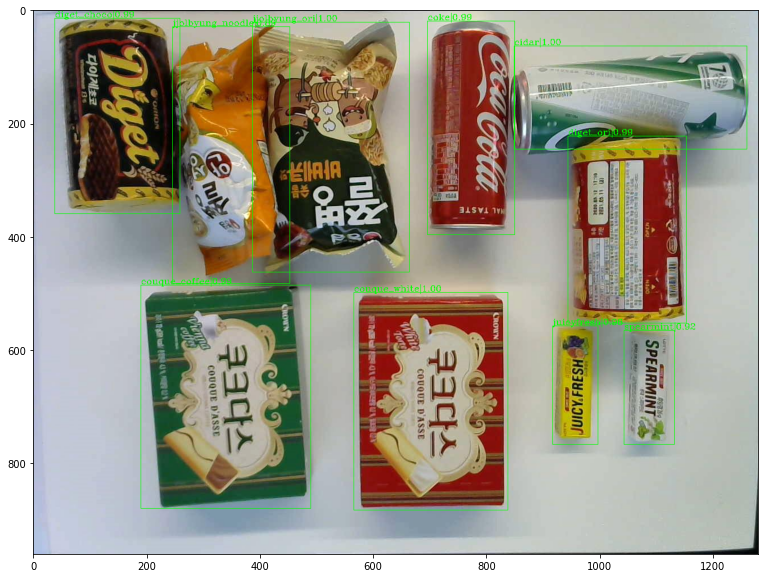

In [7]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('lotte_data/training/JPEGImages/0426.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [6]:
torch.save(model.state_dict(), 'state_dicts/Dynamic_RCNN_model_state_dict')